In [464]:
#loading packages
library(tidyverse)

library(stringr)

library(plyr)

library(dplyr)

library(openxlsx)

library(ggplot2)

In [465]:
#loading data

TotalAdds <- read_csv("DataAnalyst_Ecom_data_addsToCart.csv")
DeviceSpecs <- read_csv("DataAnalyst_Ecom_data_sessionCounts.csv")

head(TotalAdds)
head(DeviceSpecs)

Parsed with column specification:
cols(
  dim_year = col_double(),
  dim_month = col_double(),
  addsToCart = col_double()
)

Parsed with column specification:
cols(
  dim_browser = col_character(),
  dim_deviceCategory = col_character(),
  dim_date = col_character(),
  sessions = col_double(),
  transactions = col_double(),
  QTY = col_double()
)



dim_year,dim_month,addsToCart
<dbl>,<dbl>,<dbl>
2012,7,191504
2012,8,217666
2012,9,123726
2012,10,139803
2012,11,186572
2012,12,168972


dim_browser,dim_deviceCategory,dim_date,sessions,transactions,QTY
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Safari,tablet,7/1/12,2928,127,221
Internet Explorer,desktop,7/1/12,1106,28,0
Chrome,tablet,7/1/12,474,3,13
Amazon Silk,tablet,7/1/12,235,4,5
Internet Explorer,mobile,7/1/12,178,6,11
Internet Explorer,tablet,7/1/12,120,7,0


In [466]:
#EDA
summary(TotalAdds)
summary(DeviceSpecs)

    dim_year      dim_month       addsToCart    
 Min.   :2012   Min.   : 1.00   Min.   :107970  
 1st Qu.:2012   1st Qu.: 3.75   1st Qu.:132843  
 Median :2012   Median : 6.50   Median :143711  
 Mean   :2012   Mean   : 6.50   Mean   :154173  
 3rd Qu.:2013   3rd Qu.: 9.25   3rd Qu.:184525  
 Max.   :2013   Max.   :12.00   Max.   :217666  

 dim_browser        dim_deviceCategory   dim_date            sessions    
 Length:7734        Length:7734        Length:7734        Min.   :    0  
 Class :character   Class :character   Class :character   1st Qu.:    3  
 Mode  :character   Mode  :character   Mode  :character   Median :   23  
                                                          Mean   : 1347  
                                                          3rd Qu.:  772  
                                                          Max.   :43559  
  transactions          QTY         
 Min.   :   0.00   Min.   :   0.00  
 1st Qu.:   0.00   1st Qu.:   0.00  
 Median :   0.00   Median :   0.00  
 Mean   :  32.28   Mean   :  58.29  
 3rd Qu.:   9.00   3rd Qu.:  12.00  
 Max.   :1398.00   Max.   :2665.00  

# Creating a Month * Device aggregation of data

In [491]:
#editing date to just hold the month value
dateVals <- unique(DeviceSpecs$dim_date) 
DeviceSpecs$month <- str_extract(DeviceSpecs$dim_date,"12|11|10|9|8|7|6|5|4|3|2|1") 
dateVals <- unique(DeviceSpecs$month) 

In [468]:
#changing month type to numeric
DeviceSpecs$month <-  as.numeric(DeviceSpecs$month)
#summary(DeviceSpecs)

In [492]:
#getting rid of dim_browser and dim_date since they are not relevant
DeviceSpecs2 <- DeviceSpecs[c(-1,-3)]
head(DeviceSpecs2)

dim_deviceCategory,sessions,transactions,QTY,month
<chr>,<dbl>,<dbl>,<dbl>,<chr>
tablet,2928,127,221,7
desktop,1106,28,0,7
tablet,474,3,13,7
tablet,235,4,5,7
mobile,178,6,11,7
tablet,120,7,0,7


In [493]:
#aggregate based on month and dim_deviceCategory
DeviceSpecsSum <- ddply(DeviceSpecs,.(month,dim_deviceCategory),numcolwise(sum))
head(DeviceSpecsSum)

,month,dim_deviceCategory,sessions,transactions,QTY
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,1,desktop,393723,13793,25424
2,1,mobile,341668,4360,7257
3,1,tablet,164601,3407,6165
4,10,desktop,302682,9373,17675
5,10,mobile,238849,2418,4446
6,10,tablet,107108,2484,4505


In [471]:
#adding a ECR (= Transactions / Sessions) variable
DeviceSpecsSum$ECR <- DeviceSpecsSum$transactions/DeviceSpecsSum$sessions
head(DeviceSpecsSum)
MonthDevice <- DeviceSpecsSum

,month,dim_deviceCategory,sessions,transactions,QTY,ECR
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,desktop,393723,13793,25424,0.03503224
2,1,mobile,341668,4360,7257,0.01276093
3,1,tablet,164601,3407,6165,0.02069854
4,2,desktop,247632,9699,18437,0.03916699
5,2,mobile,194996,2071,3915,0.01062073
6,2,tablet,107599,2396,4696,0.02226786


In [472]:
#pivoting data
DeviceSpecsShape <- pivot_wider(DeviceSpecsSum,names_from= 'dim_deviceCategory', 
                                values_from = c('sessions','transactions','QTY','ECR'))
DeviceSpecsShape <- DeviceSpecsShape[order(DeviceSpecsShape$month),]
head(DeviceSpecsShape)


month,sessions_desktop,sessions_mobile,sessions_tablet,transactions_desktop,transactions_mobile,transactions_tablet,QTY_desktop,QTY_mobile,QTY_tablet,ECR_desktop,ECR_mobile,ECR_tablet
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,393723,341668,164601,13793,4360,3407,25424,7257,6165,0.03503224,0.012760926,0.02069854
2,247632,194996,107599,9699,2071,2396,18437,3915,4696,0.03916699,0.010620731,0.02226786
3,287837,304832,196151,9679,3644,4481,17362,6455,8265,0.03362667,0.011954126,0.02284465
4,567510,429864,299239,18868,4280,7221,34200,7752,12994,0.03324699,0.009956637,0.02413121
5,526330,409796,228513,18176,5413,4800,33208,9790,8631,0.03453347,0.013209011,0.02100537
6,554940,526481,307413,19370,7412,7756,35146,13017,13728,0.03490467,0.014078381,0.02522990


In [473]:
#rename columns
colnames(DeviceSpecsShape)<- c('Month','Desktop Sessions',
                               'Mobile Sessions','Tablet Sessions','Desktop Transactions',
                               'Mobile Transactions','Tablet Transactions','Desktop QTY',
                               'Mobile QTY','Tablet QTY','Desktop ECR','Mobile ECR','Tablet ECR')
head(DeviceSpecsShape)

Month,Desktop Sessions,Mobile Sessions,Tablet Sessions,Desktop Transactions,Mobile Transactions,Tablet Transactions,Desktop QTY,Mobile QTY,Tablet QTY,Desktop ECR,Mobile ECR,Tablet ECR
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,393723,341668,164601,13793,4360,3407,25424,7257,6165,0.03503224,0.012760926,0.02069854
2,247632,194996,107599,9699,2071,2396,18437,3915,4696,0.03916699,0.010620731,0.02226786
3,287837,304832,196151,9679,3644,4481,17362,6455,8265,0.03362667,0.011954126,0.02284465
4,567510,429864,299239,18868,4280,7221,34200,7752,12994,0.03324699,0.009956637,0.02413121
5,526330,409796,228513,18176,5413,4800,33208,9790,8631,0.03453347,0.013209011,0.02100537
6,554940,526481,307413,19370,7412,7756,35146,13017,13728,0.03490467,0.014078381,0.02522990


In [474]:
#manually ordering based on month and year
DeviceSpecsShape <-DeviceSpecsShape %>% arrange(factor(Month, levels = c(7,8,9,10,11,12,1,2,3,4,5,6)))

# Creating a Month over Month comparison 

In [475]:
#keeping months 5 and 6
DeviceSpecsMonth<-DeviceSpecs %>% filter(month  %in% c(5, 6))
head(DeviceSpecsMonth)

dim_browser,dim_deviceCategory,dim_date,sessions,transactions,QTY,month
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Safari,tablet,5/1/13,11440,290,654,5
Safari,mobile,5/1/13,9778,69,147,5
Firefox,desktop,5/1/13,3490,74,182,5
Internet Explorer,desktop,5/1/13,913,45,65,5
Edge,desktop,5/1/13,475,14,8,5
Chrome,tablet,5/1/13,181,1,7,5


In [476]:
#aggregate based on month,dim_deviceCategory, and dim_browser
DeviceSpecsMonthSum <- ddply(DeviceSpecsMonth,.(month,dim_deviceCategory,dim_browser),numcolwise(sum))
head(DeviceSpecsMonthSum)

,month,dim_deviceCategory,dim_browser,sessions,transactions,QTY
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,5,desktop,Amazon Silk,6,0,0
2,5,desktop,Apple-iPhone7C2,0,0,0
3,5,desktop,Chrome,232256,7345,13852
4,5,desktop,Chromeless 1.2.0,1,0,0
5,5,desktop,Coc Coc,6,0,0
6,5,desktop,DDG-Android-3.1.1,5,0,0


In [477]:
#split into dataframes with month values 5 and 6
df5 <- DeviceSpecsMonthSum[DeviceSpecsMonthSum$month == 5, ]
df6 <- DeviceSpecsMonthSum[DeviceSpecsMonthSum$month == 6, ]

df5and6 <- merge(df5,df6,by=c("dim_deviceCategory","dim_browser"))

colnames(df5and6)<- c('DeviceCategory', 'Browser', 'PreviousMonth', 'PreviousSessions', 'PreviousTransactions', 
                     'PreviousQTY', 'RecentMonth', 'RecentSessions', 'RecentTransactions', 'RecentQTY')
#adding columns to merge df5and6 with totalAdds
df5and6["PreviousAddsToCart"] <- 0
df5and6["RecentAddsToCart"] <- 0

In [478]:
#Manipulating TotalAdds so it can be merged with df5and6
df5total <- TotalAdds[TotalAdds$dim_month == 5, ]
df6total <- TotalAdds[TotalAdds$dim_month == 6, ]

df5and6Total <- merge(df5total,df6total,by="dim_year")
colnames(df5and6Total)<-c('Year','PreviousMonth','PreviousAddsToCart','RecentMonth', 'RecentAddsToCart' )

df5and6Total <- subset(df5and6Total, select=c('PreviousMonth','PreviousAddsToCart','RecentMonth', 'RecentAddsToCart'))

#making sure columns match
df5and6Total["DeviceCategory"] <- 'none'
df5and6Total["Browser"] <- 'none'
df5and6Total["PreviousSessions"] <- 0
df5and6Total["PreviousTransactions"] <- 0
df5and6Total["PreviousQTY"] <- 0
df5and6Total["RecentSessions"] <- 0
df5and6Total["RecentTransactions"] <- 0
df5and6Total["RecentQTY"] <- 0

df5and6Total

,PreviousMonth,PreviousAddsToCart,RecentMonth,RecentAddsToCart,DeviceCategory,Browser,PreviousSessions,PreviousTransactions,PreviousQTY,RecentSessions,RecentTransactions,RecentQTY
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5,136720,6,107970,none,none,0,0,0,0,0,0


In [479]:
#merging the dataframes
finaldf <- rbind(df5and6, df5and6Total)
head(finaldf)

,DeviceCategory,Browser,PreviousMonth,PreviousSessions,PreviousTransactions,PreviousQTY,RecentMonth,RecentSessions,RecentTransactions,RecentQTY,PreviousAddsToCart,RecentAddsToCart
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,desktop,Chrome,5,232256,7345,13852,6,235084,7789,14863,0,0
2,desktop,Coc Coc,5,6,0,0,6,20,0,0,0,0
3,desktop,DDG-Android-3.1.1,5,5,0,0,6,2,0,0,0,0
4,desktop,DESKTOP,5,40,0,0,6,12,0,0,0,0
5,desktop,Edge,5,28263,949,1702,6,26844,720,1390,0,0
6,desktop,error,5,255,0,0,6,308,0,0,0,0


In [480]:
#adding the month*month calculations- 
#(Value this month – Value previous month) x 100 / Previous month
finaldf['MoMSessionsREL']=(finaldf$RecentSessions-finaldf$PreviousSessions)*100/finaldf$PreviousSessions
finaldf['MoMSessionsABS']=abs((finaldf$RecentSessions-finaldf$PreviousSessions)*100/finaldf$PreviousSessions)

finaldf['MoMTransactionsREL']=(finaldf$RecentTransactions-finaldf$PreviousTransactions)*100/finaldf$PreviousTransactions
finaldf['MoMTransactionsABS']=abs((finaldf$RecentTransactions-finaldf$PreviousTransactions)*100/finaldf$PreviousTransactions)

finaldf['MoMqtyREL']=(finaldf$RecentQTY-finaldf$PreviousQTY)*100/finaldf$PreviousQTY
finaldf['MoMqtyABS']=abs((finaldf$RecentQTY-finaldf$PreviousQTY)*100/finaldf$PreviousQTY)

finaldf['MoMAddsToCartREL']=(finaldf$RecentAddsToCart-finaldf$PreviousAddsToCart)*100/finaldf$PreviousAddsToCart
finaldf['MoMAddsToCartABS']=abs((finaldf$RecentAddsToCart-finaldf$PreviousAddsToCart)*100/finaldf$PreviousAddsToCart)
head(finaldf,10)

,DeviceCategory,Browser,PreviousMonth,PreviousSessions,PreviousTransactions,PreviousQTY,RecentMonth,RecentSessions,RecentTransactions,RecentQTY,PreviousAddsToCart,RecentAddsToCart,MoMSessionsREL,MoMSessionsABS,MoMTransactionsREL,MoMTransactionsABS,MoMqtyREL,MoMqtyABS,MoMAddsToCartREL,MoMAddsToCartABS
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,desktop,Chrome,5,232256,7345,13852,6,235084,7789,14863,0,0,1.217622,1.217622,6.044929,6.044929,7.298585,7.298585,NaN,NaN
2,desktop,Coc Coc,5,6,0,0,6,20,0,0,0,0,233.333333,233.333333,NaN,NaN,NaN,NaN,NaN,NaN
3,desktop,DDG-Android-3.1.1,5,5,0,0,6,2,0,0,0,0,-60.000000,60.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,desktop,DESKTOP,5,40,0,0,6,12,0,0,0,0,-70.000000,70.000000,NaN,NaN,NaN,NaN,NaN,NaN
5,desktop,Edge,5,28263,949,1702,6,26844,720,1390,0,0,-5.020698,5.020698,-24.130664,24.130664,-18.331375,18.331375,NaN,NaN
6,desktop,error,5,255,0,0,6,308,0,0,0,0,20.784314,20.784314,NaN,NaN,NaN,NaN,NaN,NaN
7,desktop,Firefox,5,45462,1538,2828,6,56214,2000,3516,0,0,23.650521,23.650521,30.039012,30.039012,24.328147,24.328147,NaN,NaN
8,desktop,Internet Explorer,5,50831,1559,1512,6,44165,1378,675,0,0,-13.114045,13.114045,-11.610006,11.610006,-55.357143,55.357143,NaN,NaN
9,desktop,Maxthon,5,44,0,0,6,39,0,0,0,0,-11.363636,11.363636,NaN,NaN,NaN,NaN,NaN,NaN


In [481]:
#replacing NaN with 0
 finaldf[is.na(finaldf)] = 0
head(finaldf,10)

,DeviceCategory,Browser,PreviousMonth,PreviousSessions,PreviousTransactions,PreviousQTY,RecentMonth,RecentSessions,RecentTransactions,RecentQTY,PreviousAddsToCart,RecentAddsToCart,MoMSessionsREL,MoMSessionsABS,MoMTransactionsREL,MoMTransactionsABS,MoMqtyREL,MoMqtyABS,MoMAddsToCartREL,MoMAddsToCartABS
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,desktop,Chrome,5,232256,7345,13852,6,235084,7789,14863,0,0,1.217622,1.217622,6.044929,6.044929,7.298585,7.298585,0,0
2,desktop,Coc Coc,5,6,0,0,6,20,0,0,0,0,233.333333,233.333333,0.000000,0.000000,0.000000,0.000000,0,0
3,desktop,DDG-Android-3.1.1,5,5,0,0,6,2,0,0,0,0,-60.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0,0
4,desktop,DESKTOP,5,40,0,0,6,12,0,0,0,0,-70.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0,0
5,desktop,Edge,5,28263,949,1702,6,26844,720,1390,0,0,-5.020698,5.020698,-24.130664,24.130664,-18.331375,18.331375,0,0
6,desktop,error,5,255,0,0,6,308,0,0,0,0,20.784314,20.784314,0.000000,0.000000,0.000000,0.000000,0,0
7,desktop,Firefox,5,45462,1538,2828,6,56214,2000,3516,0,0,23.650521,23.650521,30.039012,30.039012,24.328147,24.328147,0,0
8,desktop,Internet Explorer,5,50831,1559,1512,6,44165,1378,675,0,0,-13.114045,13.114045,-11.610006,11.610006,-55.357143,55.357143,0,0
9,desktop,Maxthon,5,44,0,0,6,39,0,0,0,0,-11.363636,11.363636,0.000000,0.000000,0.000000,0.000000,0,0


In [482]:
#I'm not sure how to handle infinity- 
#I decided to change them all to 100 since they show growth
finaldf[mapply(is.infinite, finaldf)] <- 100
head(finaldf)

,DeviceCategory,Browser,PreviousMonth,PreviousSessions,PreviousTransactions,PreviousQTY,RecentMonth,RecentSessions,RecentTransactions,RecentQTY,PreviousAddsToCart,RecentAddsToCart,MoMSessionsREL,MoMSessionsABS,MoMTransactionsREL,MoMTransactionsABS,MoMqtyREL,MoMqtyABS,MoMAddsToCartREL,MoMAddsToCartABS
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,desktop,Chrome,5,232256,7345,13852,6,235084,7789,14863,0,0,1.217622,1.217622,6.044929,6.044929,7.298585,7.298585,0,0
2,desktop,Coc Coc,5,6,0,0,6,20,0,0,0,0,233.333333,233.333333,0.000000,0.000000,0.000000,0.000000,0,0
3,desktop,DDG-Android-3.1.1,5,5,0,0,6,2,0,0,0,0,-60.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0,0
4,desktop,DESKTOP,5,40,0,0,6,12,0,0,0,0,-70.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0,0
5,desktop,Edge,5,28263,949,1702,6,26844,720,1390,0,0,-5.020698,5.020698,-24.130664,24.130664,-18.331375,18.331375,0,0
6,desktop,error,5,255,0,0,6,308,0,0,0,0,20.784314,20.784314,0.000000,0.000000,0.000000,0.000000,0,0


In [483]:
#ordering df to show most QTY, transactions, and sessions (relative) largest to smallest
finaldf <- finaldf[order(-finaldf$MoMqtyREL, -finaldf$MoMTransactionsREL, -finaldf$MoMSessionsREL),]

head(finaldf)

,DeviceCategory,Browser,PreviousMonth,PreviousSessions,PreviousTransactions,PreviousQTY,RecentMonth,RecentSessions,RecentTransactions,RecentQTY,PreviousAddsToCart,RecentAddsToCart,MoMSessionsREL,MoMSessionsABS,MoMTransactionsREL,MoMTransactionsABS,MoMqtyREL,MoMqtyABS,MoMAddsToCartREL,MoMAddsToCartABS
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
24,mobile,Android Webview,5,7424,7,17,6,13073,54,69,0,0,76.09106,76.09106,671.42857,671.42857,305.8824,305.8824,0,0
30,mobile,Internet Explorer,5,2731,28,36,6,1409,39,127,0,0,-48.40718,48.40718,39.28571,39.28571,252.7778,252.7778,0,0
48,tablet,Edge,5,27,0,1,6,20,0,3,0,0,-25.92593,25.92593,0.00000,0.00000,200.0000,200.0000,0,0
56,tablet,Samsung Internet,5,406,6,16,6,820,29,44,0,0,101.97044,101.97044,383.33333,383.33333,175.0000,175.0000,0,0
45,tablet,Android Webview,5,924,1,4,6,1028,11,10,0,0,11.25541,11.25541,1000.00000,1000.00000,150.0000,150.0000,0,0
31,mobile,Iron,5,3,0,0,6,12,4,4,0,0,300.00000,300.00000,100.00000,100.00000,100.0000,100.0000,0,0


In [485]:
#create workbook

#options(openxlsx.borderStyle = "thin")
#options(openxlsx.borderColour = "#4F81BD")
wb <- createWorkbook()
addWorksheet(wb,"MonthMonth")
addWorksheet(wb, "MonthDevice")
redstyle<-createStyle(fontColour = "#9C0006", bgFill = '#FFC7CE')
greenstyle <- createStyle(fontColour = "#006100", bgFill = "#C6EFCE")
graystyle <- createStyle(bgFill = '#B2BEB5')
hstyle <- createStyle(halign = "center", fontSize = 14, bgFill = "#FFFFFF")
cstyle <- createStyle(halign = "center")
desktop <- createStyle(bgFill = '#ead1dc')
tablet <- createStyle(bgFill = '#d5a6bd')
mobile <- createStyle(bgFill = '#c27ba0')


In [486]:
#adding data  to workbook with formatting
writeData(wb,"MonthMonth", finaldf, headerStyle = hstyle)
writeData(wb, "MonthDevice", DeviceSpecsShape)

addStyle(wb, "MonthMonth", cstyle, rows = 1:60, cols = 1:20, gridExpand = TRUE)
setColWidths(wb,"MonthMonth", cols = 1:20, width = 20)

addStyle(wb, "MonthDevice", cstyle, rows = 1:13, cols = 1:13, gridExpand = TRUE)
setColWidths(wb,"MonthDevice", cols = 1:13, width = 20)

#MonthMonth
conditionalFormatting(wb, "MonthMonth",
                     cols = 1:20, 
                     rows = 2:60,
                     rule = "<0",
                     style = redstyle)
conditionalFormatting(wb, "MonthMonth",
                     cols = 1:20, 
                     rows = 2:60,
                     rule = ">0",
                     style = greenstyle)
conditionalFormatting(wb, "MonthMonth",
                     cols = 1:20, 
                     rows = 2:60,
                     rule = "=0",
                     style = graystyle)
conditionalFormatting(wb, "MonthMonth",
                     cols = 1, 
                     rows = 1:60,
                     rule = '="desktop"',
                     style = desktop)
conditionalFormatting(wb, "MonthMonth",
                     cols = 1, 
                     rows = 1:60,
                     rule = '="mobile"',
                     style = mobile)
conditionalFormatting(wb, "MonthMonth",
                     cols = 1, 
                     rows = 1:60,
                     rule = '="tablet"',
                     style = tablet)
#monthDevice
conditionalFormatting(wb, "MonthDevice",
                     cols = 1:13, 
                     rows = 1,
                     rule = '>0',
                     style = tablet)
conditionalFormatting(wb, "MonthDevice",
                     cols = 1, 
                     rows = 1:13,
                     rule = '>0',
                     style = tablet)
conditionalFormatting(wb, "MonthDevice",
                     cols = 2:4, 
                     rows = 2:13,
                     rule = '>500000',
                     style = greenstyle)
conditionalFormatting(wb, "MonthDevice",
                     cols = 2:4, 
                     rows = 2:13,
                     rule = '<300000',
                     style = redstyle)
conditionalFormatting(wb, "MonthDevice",
                     cols = 5:7, 
                     rows = 2:13,
                     rule = '>10000',
                     style = greenstyle)
conditionalFormatting(wb, "MonthDevice",
                     cols = 5:7, 
                     rows = 2:13,
                     rule = '<4000',
                     style = redstyle)
conditionalFormatting(wb, "MonthDevice",
                     cols = 8:10, 
                     rows = 2:13,
                     rule = '>30000',
                     style = greenstyle)
conditionalFormatting(wb, "MonthDevice",
                     cols = 8:10, 
                     rows = 2:13,
                     rule = '<5000',
                     style = redstyle)
conditionalFormatting(wb, "MonthDevice",
                     cols = 11:13, 
                     rows = 2:13,
                     rule = '>.032',
                     style = greenstyle)
conditionalFormatting(wb, "MonthDevice",
                     cols = 11:13, 
                     rows = 2:13,
                     rule = '<.02',
                     style = redstyle)


saveWorkbook(wb,"IXIS.xlsx", TRUE)


# Creating some visualizations

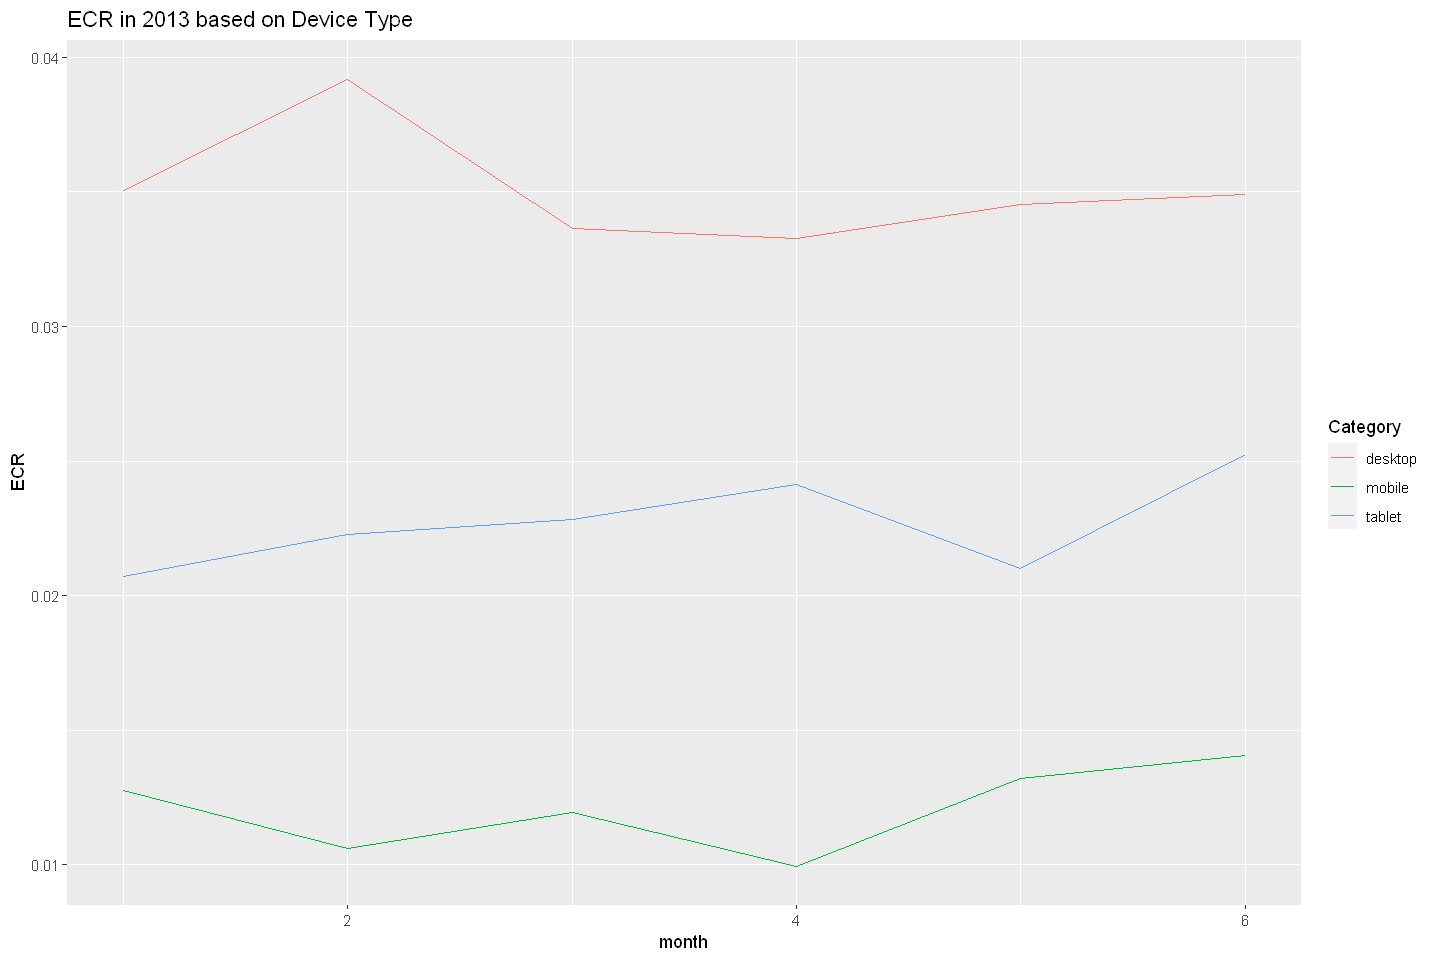

In [487]:
#for the MonthDevice data
MD2 <- MonthDevice %>% filter(month < 7)
plot <- ggplot(MD2, aes(x = month, y = ECR, colour = dim_deviceCategory)) +
  geom_line()+
  labs(title = "ECR in 2013 based on Device Type",colour = "Category")
plot



In [488]:
#change plot size
options(repr.plot.width = 12, repr.plot.height = 8)

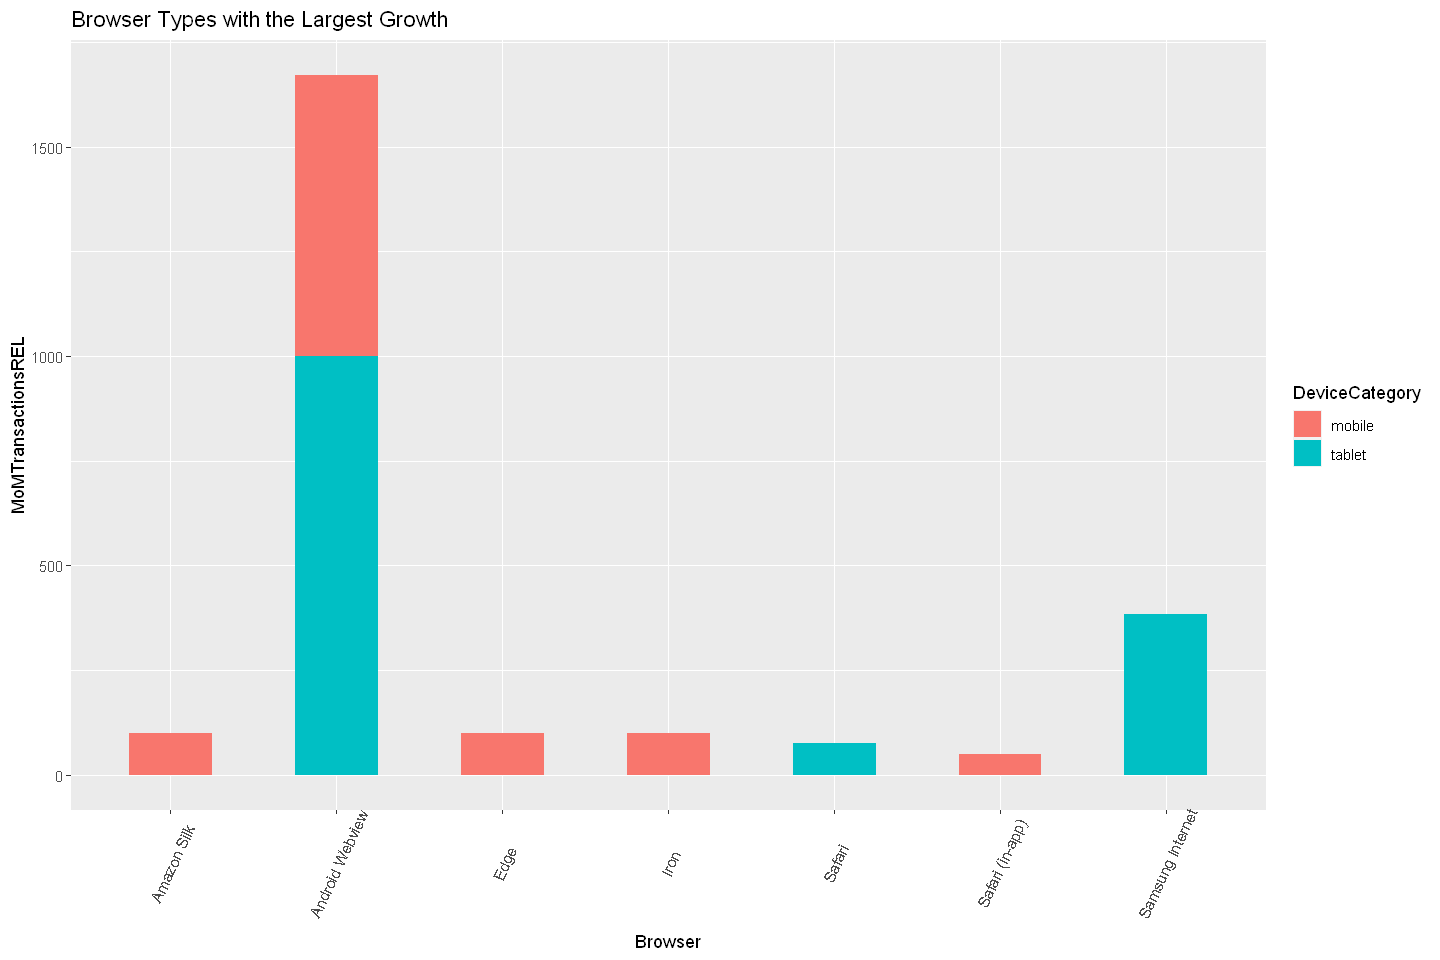

In [489]:
#looking at MOMQTY relative trends

momTrend <- finaldf[order(finaldf$MoMTransactionsREL), ]  
momWorst<- head(momTrend,8)
momBest <- tail(momTrend, 8)

ggplot(momBest, aes(x=Browser, y=MoMTransactionsREL, fill = DeviceCategory)) + 
  geom_bar(stat="identity", width=.5) + 
  labs(title="Browser Types with the Largest Growth")+        
  theme(axis.text.x = element_text(angle=65, vjust=0.6))

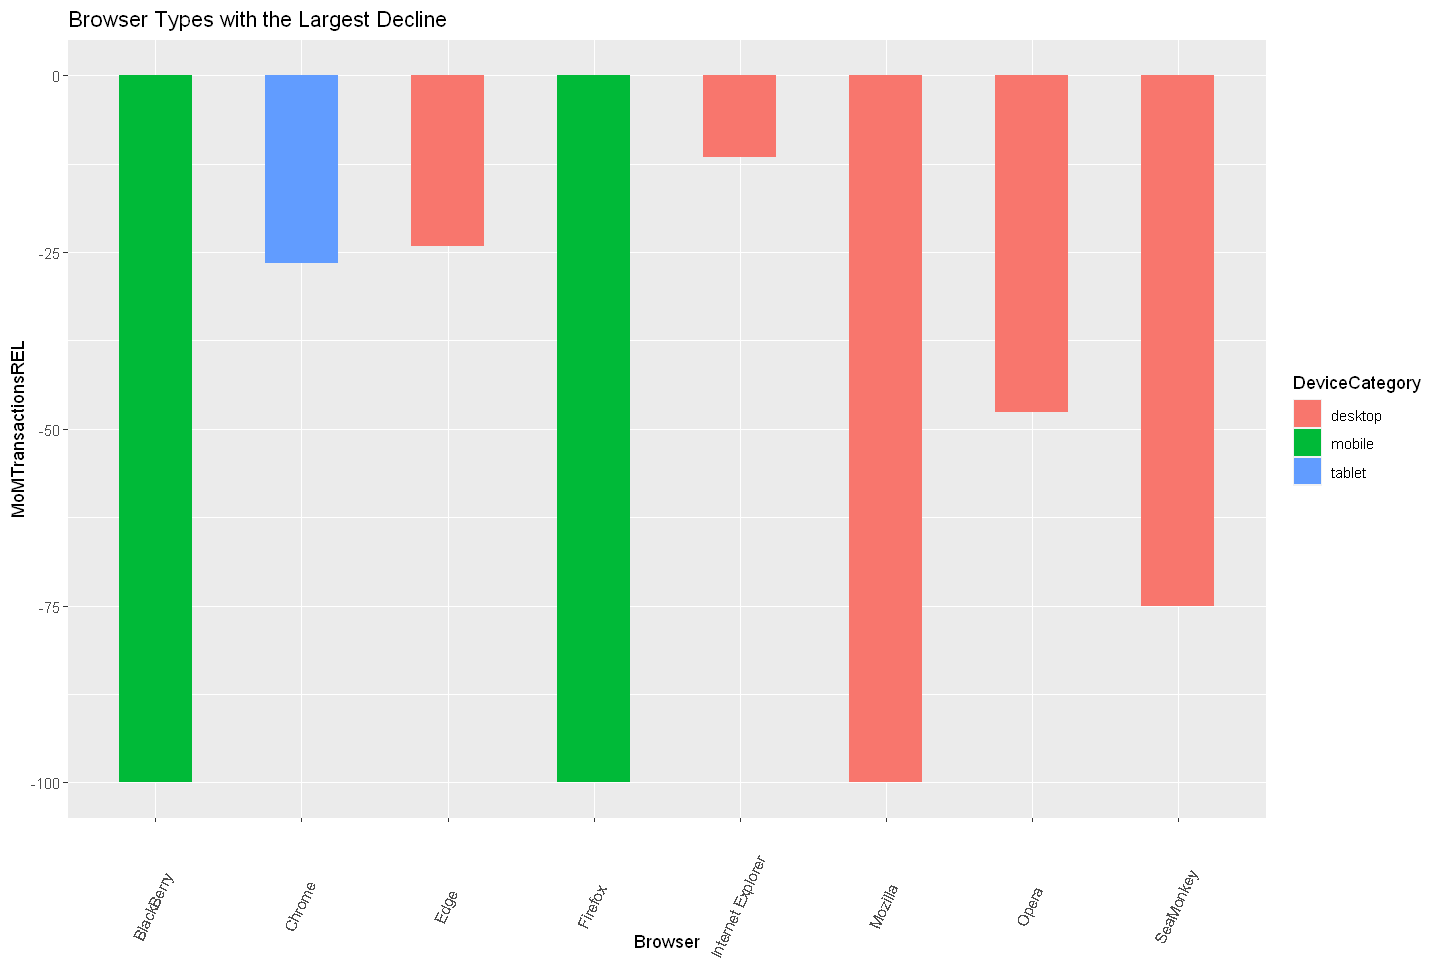

In [490]:
ggplot(momWorst, aes(x=Browser, y=MoMTransactionsREL, fill = DeviceCategory)) + 
  geom_bar(stat="identity", width=.5) + 
  labs(title="Browser Types with the Largest Decline")+        
  theme(axis.text.x = element_text(angle=65, vjust=0.2))